# Reference
https://github.com/geee05/ARIMA/blob/main/ARIMA%20%20Case%20Study%20Final%20Airline%20Passenger%20Data.ipynb

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose #for dealing with seasonality in data
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

Load raw CSV into DataFrame, converts that string into an actual date object pandas understands, makes Datetime the row label instead of 0, 1, 2... so you can slice by date.

In [46]:
import pandas as pd

data = pd.read_csv(r'C:\Users\Sumfl\OneDrive\Documents\GitHub\ctc-esg\model-training\chillerdata1.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)
data.set_index('Datetime', inplace=True)
data = data.asfreq('min')

print(data.index)
print(data.isnull().sum())

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 01:01:00',
               '2018-01-01 01:02:00', '2018-01-01 01:03:00',
               '2018-01-01 01:04:00', '2018-01-01 01:05:00',
               '2018-01-01 01:06:00', '2018-01-01 01:07:00',
               '2018-01-01 01:08:00', '2018-01-01 01:09:00',
               ...
               '2018-12-31 23:50:00', '2018-12-31 23:51:00',
               '2018-12-31 23:52:00', '2018-12-31 23:53:00',
               '2018-12-31 23:54:00', '2018-12-31 23:55:00',
               '2018-12-31 23:56:00', '2018-12-31 23:57:00',
               '2018-12-31 23:58:00', '2018-12-31 23:59:00'],
              dtype='datetime64[us]', name='Datetime', length=525540, freq='min')
CHL_POW_1    0
dtype: int64


Slice and resample yearly data to 2 months by 10 minutes interval.

In [47]:
summer_data = data['2018-06-01':'2018-07-31']
summer_resampled = summer_data['CHL_POW_1'].resample('10min').mean()

print(summer_resampled.shape)
print(summer_resampled.head())

(8784,)
Datetime
2018-06-01 00:00:00    2.646288
2018-06-01 00:10:00    2.120376
2018-06-01 00:20:00    2.129914
2018-06-01 00:30:00    2.139829
2018-06-01 00:40:00    2.150064
Freq: 10min, Name: CHL_POW_1, dtype: float64


<Axes: title={'center': '2 Months Summer Data'}, xlabel='Datetime'>

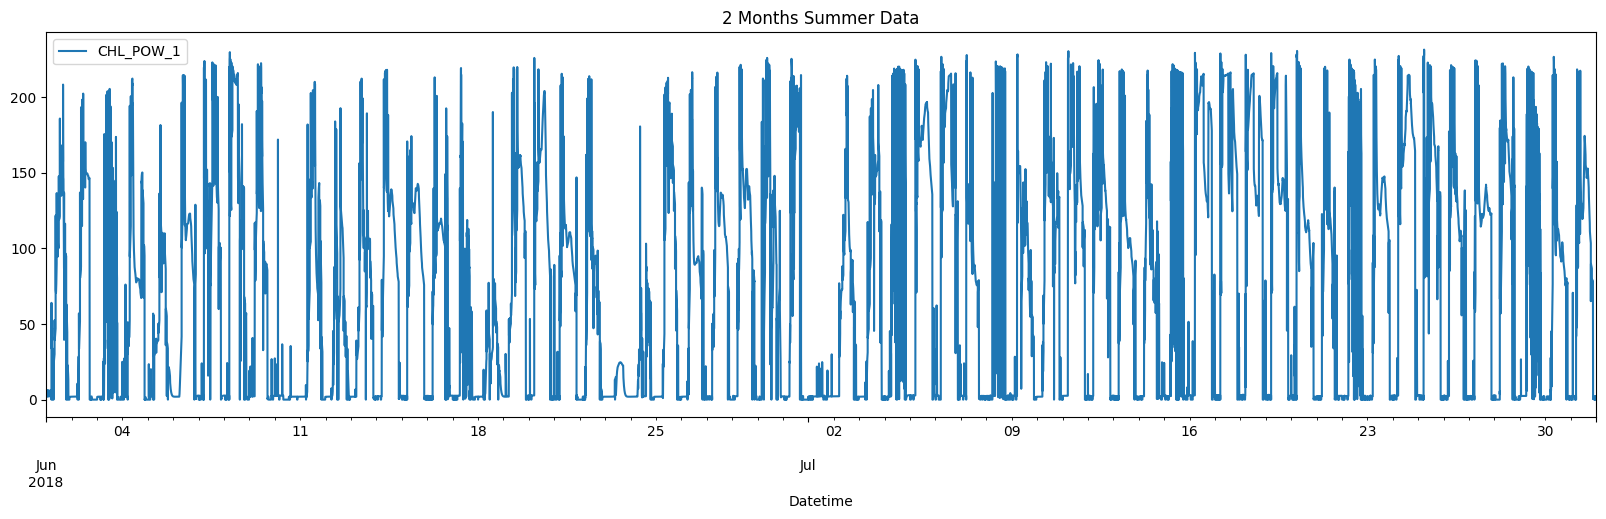

In [50]:
summer_data.plot(figsize=(20, 5), title="2 Months Summer Data")

Check for stationarity

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

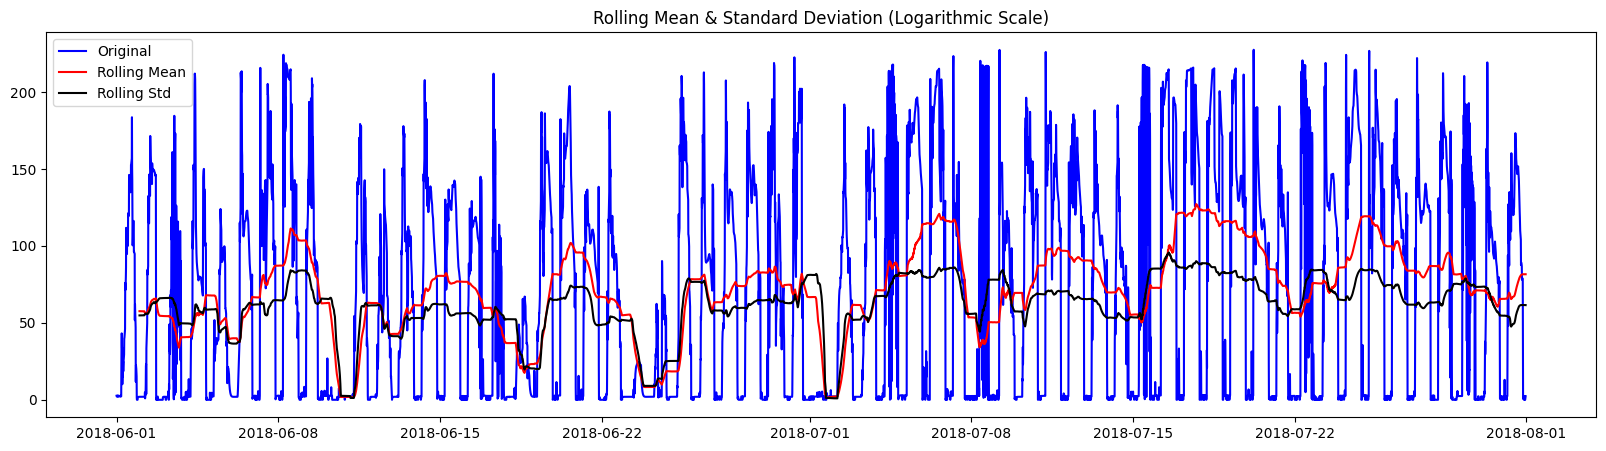

In [53]:
#checking the stationarity of the series  1.ROLLING STATS
#is the mean constant?
mean_log = summer_resampled.rolling(window=144).mean() #for moving stats value, rolling function has been used for 12 months
std_log = summer_resampled.rolling(window=144).std()

#how is the rolling mean calculated above?
#each value in the rolling mean series is the average of the current value and the previous 11 values
plt.figure(figsize=(20, 5))
plt.plot(summer_resampled, color='blue', label='Original')
plt.plot(mean_log, color='red', label='Rolling Mean')
plt.plot(std_log, color='black', label='Rolling Std')
plt.legend(loc='best') #
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')
#inference from plot : mean and std dev are varying and not constant

Statistical Check (ADF Test)

In [55]:
from statsmodels.tsa.stattools import adfuller

print('Results of ADCF Test:')
# We dropna() because the rolling window creates empty values at the start
dftest = adfuller(summer_resampled.dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of ADCF Test:
Test Statistic                -1.419334e+01
p-value                        1.840487e-26
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [ ]:
It is Stationary: Mathematically, your data's mean and variance are stable enough for the ARIMA model to make sense of the patterns.

The seasonal decomposition reveals that the chiller power consumption is dominated by a highly consistent Seasonal component, which follows a strict 24-hour cycle (s=144) typical of building operations in Singapore. The Trend is not a simple linear progression but rather a series of "slow waves," indicating periods of higher or lower base cooling demand across the two months, likely influenced by weekly occupancy or weather fluctuations. The Residual (noise) is well-behaved and largely clustered around the zero line, confirming that most of the data's variance is explained by the schedule and trend rather than random anomalies. Overall, the clear separation of these components and the stability of the residuals confirm the data is stationary and ideally suited for a SARIMA model.

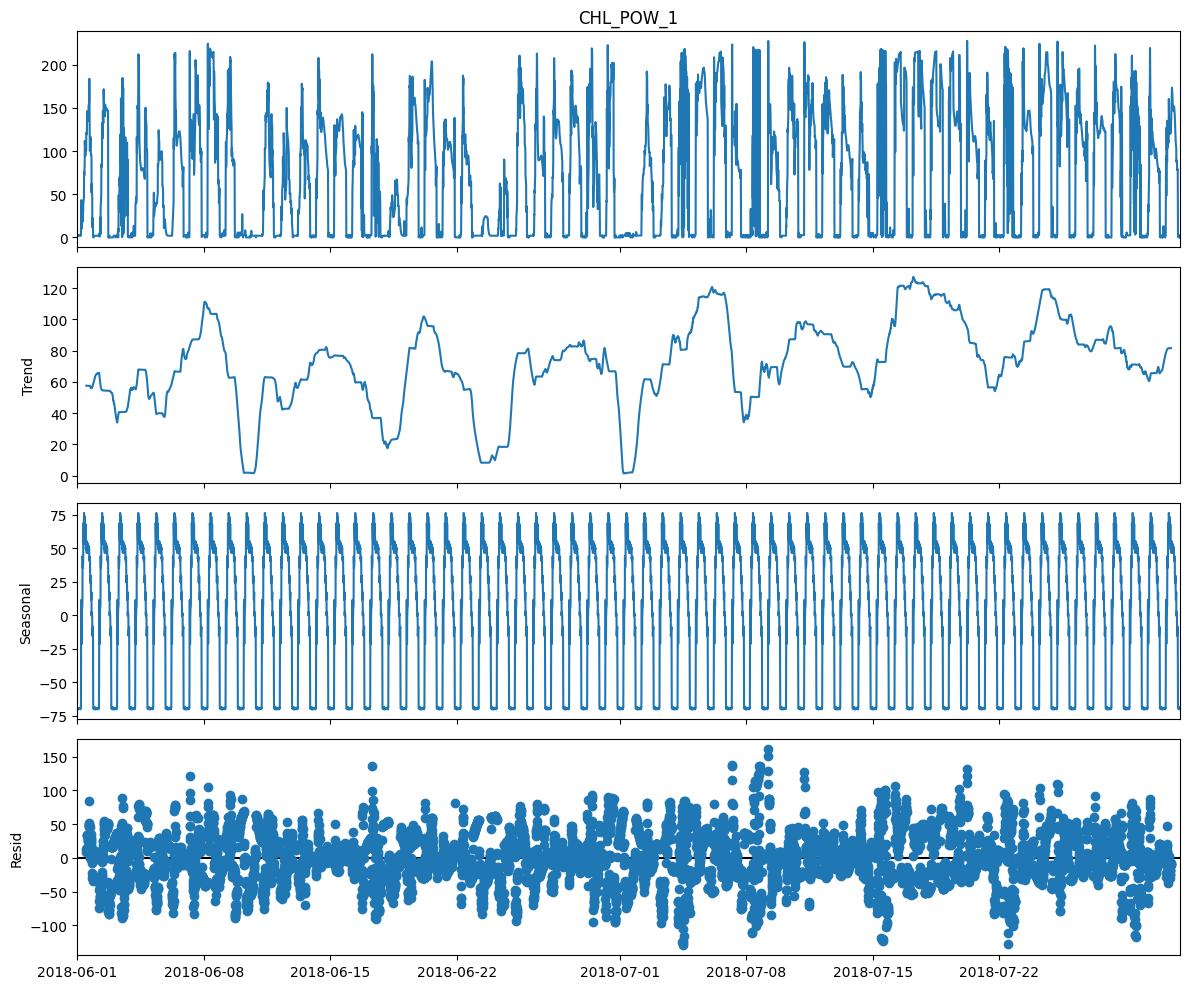

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We use period=144 because the pattern repeats every 24 hours
# Using 'multiplicative' is often better for power data, but 'additive' is safer if you have 0s
decomposition = seasonal_decompose(summer_resampled.dropna(), model='additive', period=144)

# Set the figure size to make it readable
plt.rcParams['figure.figsize'] = (12, 10)
decomposition.plot()
plt.show()

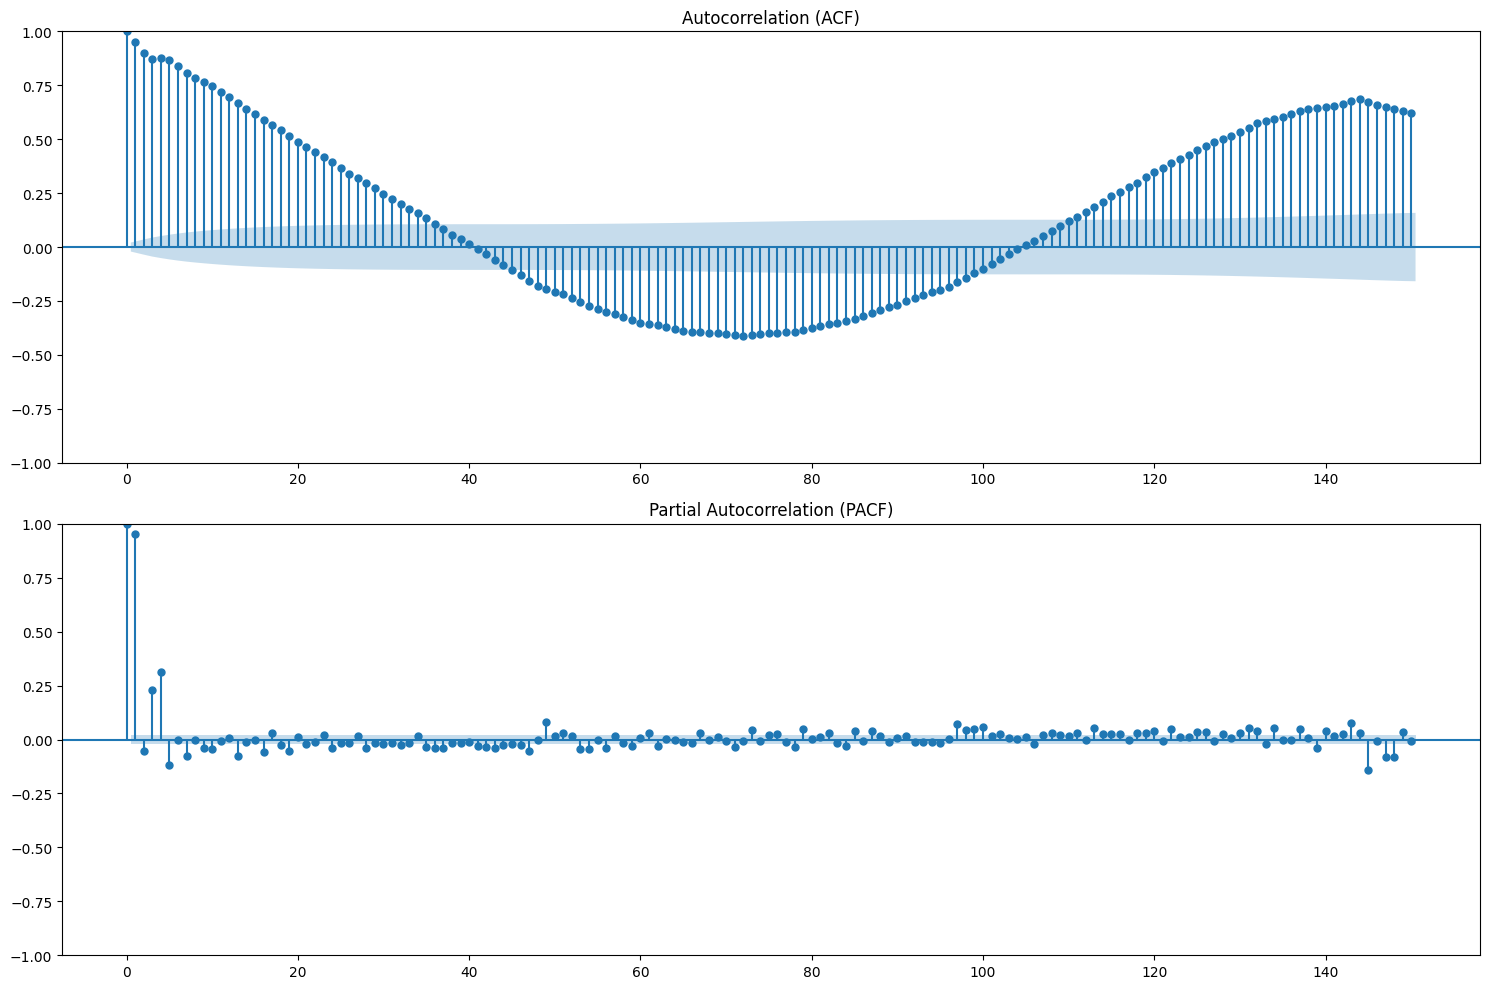

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# We use the resampled 10-minute data
# lags=150 allows us to see just over 24 hours of correlation (144 lags = 24h)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF helps determine the 'q' (Moving Average) term
plot_acf(summer_resampled.dropna(), lags=150, ax=ax1)
ax1.set_title('Autocorrelation (ACF)')

# PACF helps determine the 'p' (Autoregressive) term
plot_pacf(summer_resampled.dropna(), lags=150, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

Picking p: Since the spikes "shut off" or get much smaller after the first 2 or 3 lags (before a tiny bit of noise kicks in), your p value is likely 2.

P, D, Q, s	(1, 1, 1, 144)

p (AR)	2	The first 2 spikes in PACF are dominant.
d (Diff)	0	Your ADF test already passed (Stationary).
q (MA)	0 or 1	The ACF doesn't "cut off" sharply, it tapers.
P, D, Q, s	(1, 1, 1, 144)	The "Sine Wave" in ACF confirms we need the seasonal part.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
# order = (p, d, q)
# seasonal_order = (P, D, Q, s)
model = SARIMAX(summer_resampled, 
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 144))

# Fit the model
results = model.fit()

# Print the summary to see if the parameters are "significant"
print(results.summary())